In [1]:
import scanpy.api as sc
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex, Normalize
import seaborn as sns
from copy import deepcopy
from matplotlib import cm
%matplotlib inline

In [18]:
## Init the full dataset
rawdata = sc.read('../data/Marrow-counts.csv').transpose() 
cell_annotation = pd.read_csv('../data/annotations_FACS.csv', index_col='cell') 
rawdata.obs['cell_type'] = cell_annotation.cell_ontology_class

## Normalize w/ seurat defaults
normed = sc.pp.recipe_seurat(rawdata, log=False, plot=False, copy=True)
immutable_annotations = rawdata.obs_keys() ## log which keys were present on load (note some are added during preprocessing)

## Preprocess, compute embedding for 'universe'
sc.pp.pca(normed)
sc.pp.neighbors(normed)
sc.tl.umap(normed)

/Users/sidneybell/Library/Python/3.7/lib/python/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


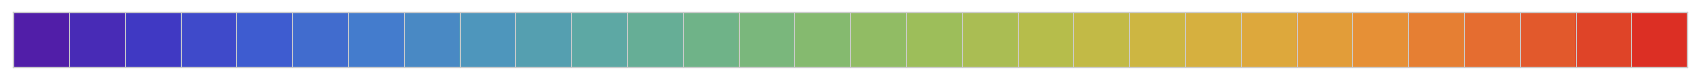

In [19]:
colors = ["#511EA8", "#482BB6", "#4039C3", "#3F4ACA", "#3E5CD0", "#416CCE", "#447CCD", "#4989C4", "#4E96BC", "#559FB0", "#5DA8A4", "#66AE96", "#6FB388", "#7AB77C", "#85BA6F", "#91BC64", "#9DBE5A", "#AABD53", "#B6BD4B", "#C2BA46", "#CDB642", "#D6B03F", "#DDA83C", "#E29D39", "#E69036", "#E67F33", "#E56D30", "#E2592C", "#DF4428", "#DC2F24"]
cmap = LinearSegmentedColormap.from_list('cmap', colors, N=len(colors))
palette = sns.color_palette(colors)
sns.set(style='whitegrid', font_scale=1.2)

sns.palplot(palette)

def assign_colors(vals, cmap=cmap):
    ''' return a dictionary of { value: (R,G,B,a) } '''
    if type(cmap) == str:
        cmap = cm.get_cmap(cmap)
    vals = set(vals)
    nvals = len(vals)
    
    colors = [cmap(i/nvals) for i in range(nvals)]
    
    return { val: colors[i] for i,val in enumerate(vals) }

In [20]:
def plot_umap(adata, colorby = 'cell_type', title=None, show=True):
    
    if colorby in adata.obs :        
        fig, ax = plt.subplots()
        color_dict = assign_colors(pd.unique(adata.obs[colorby]))
        colors = [ color_dict[k] for k in adata.obs[colorby] ]
        legend_handles = []
        for val, color in color_dict.items():
            patch = patches.Patch(color=color, label=val)
            legend_handles.append(patch)

        plt.legend(loc=(1,0),handles=legend_handles, ncol=2)

    elif colorby in adata.var_names:
        fig, (ax, cax) = plt.subplots(ncols=2, gridspec_kw={'width_ratios': [1, 0.1]})
        plt.sca(ax)

        vals = adata[:, adata.var_names.isin([colorby])].X
        cmap = plt.cm.viridis
        norm = Normalize(np.percentile(vals, 2), np.percentile(vals, 98))
        colors = [plt.cm.viridis(norm(v)) for v in vals]
        
        colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='vertical', 
                                alpha=0.5, label=colorby)   
        
    plt.scatter(adata.obsm['X_umap'][:,0], adata.obsm['X_umap'][:,1], c=colors, alpha=0.2)
    

    if title:
        ax.set_title(title)
        
    if show:
        plt.show()
    return fig, ax

# Plot universe

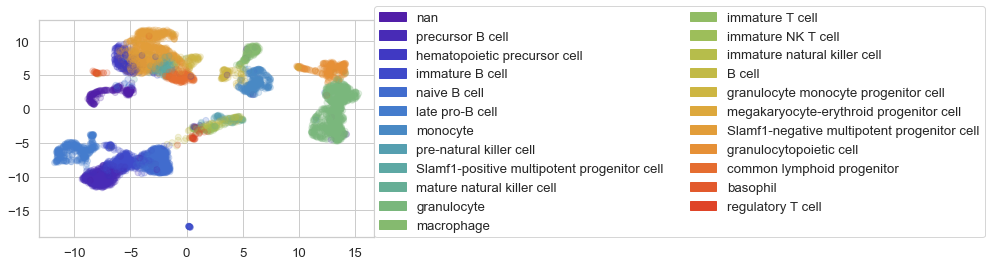

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x149a9b978>)

In [21]:
plot_umap(normed)

# Let's try to find and annotate some proliferating B cells

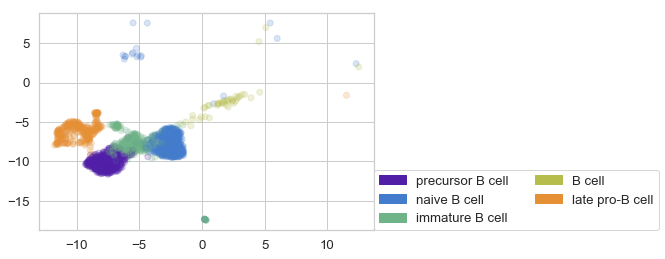

Text(0.5, 1.0, 'Original embedding')

In [22]:
## Categorical selection based on cell type

cell_types = pd.unique(normed.obs['cell_type'].values)
B_cell_values = [c for c in cell_types if 'B cell' in str(c)]

B_cells = normed[normed.obs['cell_type'].isin(B_cell_values)]

fig, ax = plot_umap(B_cells)
ax.set_title('Original embedding')

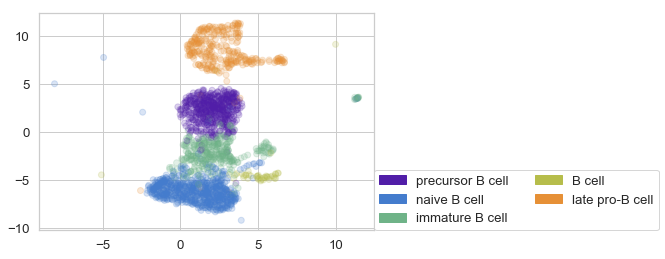

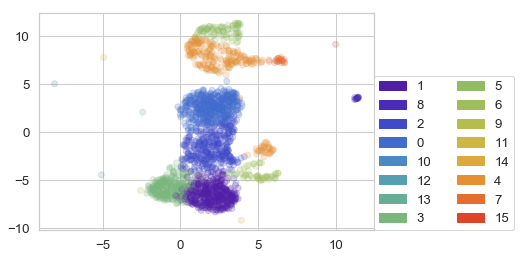

In [23]:
## Rerun umap & cluster just the B cells to look at local structure and increase resolution

sc.tl.umap(B_cells)
sc.tl.louvain(B_cells)

fig, ax = plot_umap(B_cells, colorby='cell_type')
fig, ax = plot_umap(B_cells, colorby='louvain')

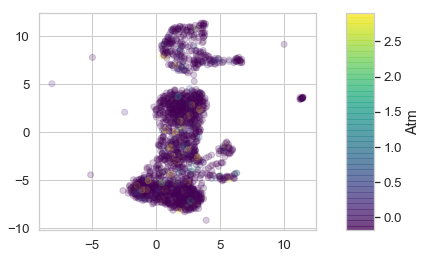

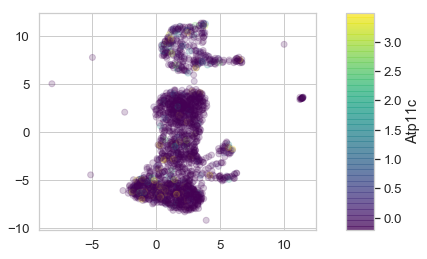

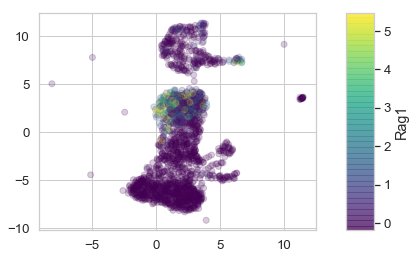

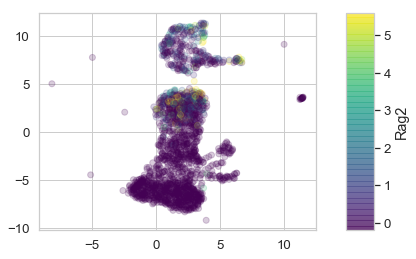

In [24]:
## Look for proliferation marker genes (via http://www.informatics.jax.org/go/term/GO:0002322 )
markers = ['Abl1', 'Atm', 'Atp11c', 'Cd24a', 'Fnip1', 'Foxp1', 'Irf2bp2', 'Kit', 'Mir17', 'Mir18', 'Mir19a', 'Mir20a', 'Rag1', 'Rag2']

for marker in markers:
    if marker in B_cells.var_names:    
        plot_umap(B_cells, marker)
    

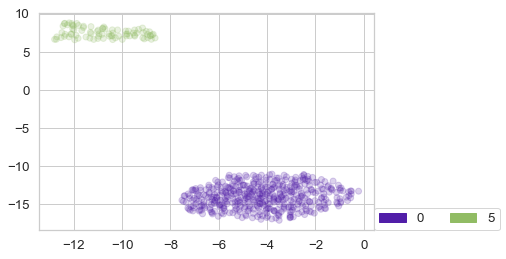

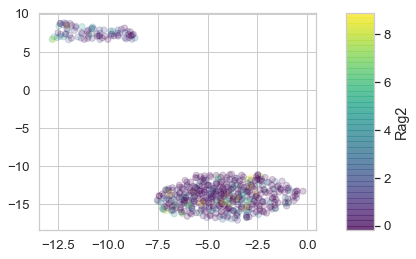

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12b1cac88>)

In [25]:
## Cross referencing these, it looks like the cells in clusters 0 and 5 are expressing proliferation markers.
prolif = B_cells[B_cells.obs['louvain'].isin(['0', '5',])]

sc.tl.umap(prolif)
plot_umap(prolif, 'louvain')
plot_umap(prolif, 'Rag2')

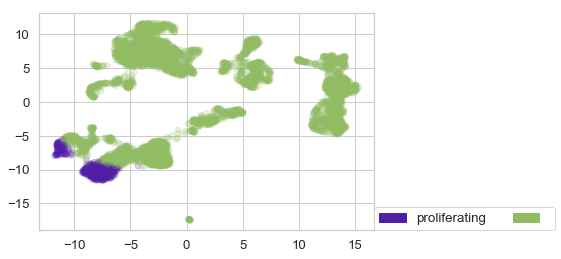

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12b14f5f8>)

In [26]:
## Make a new column to store this annotation
## Alternatively, this could be implemented as a separate dataframe, 
## but adding it directly to the anndata object in memory lets the rest of the plotting machinery access it easily

prolif_index = prolif.obs_names
activation_state = []
for k in normed.obs_names:
    if k in prolif_index:
        activation_state.append('proliferating')
    else:
        activation_state.append(None)
    
normed.obs['activation'] = activation_state

plot_umap(normed, 'activation')

In [28]:
new_annotations = [c for c in normed.obs_keys() if c not in immutable_annotations]
print(new_annotations)

['n_genes', 'n_counts', 'activation']
